# 第6回講義 演習

## 目次

課題. 高度な画像認識の実装と学習
    1. CIFAR-10データセットの読み込みと可視化
    2. Data Augmentation
        - 2.1. Flipping (horizontally)
        - 2.2. Random cropping
    3. Preprocessing
        - 3.1. Global Contrast Normalization (GCN)
        - 3.2. Zero-phase Component Analysis (ZCA) Whitening
    4. Batch Normalization
    5. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習
        - 5.1. 各層クラスの実装
        - 5.2. 計算グラフ構築 & パラメータの更新設定
        - 5.3. 学習
    6. Activationの可視化
        - 6.1. conv1
        - 6.2. conv2
        - 6.3. conv3
    7. tf.layers の利用
        - 7.1. ネットワークの実装
        - 7.2. 学習

## 課題. 高度な画像認識の実装と学習

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.datasets import cifar10

rng = np.random.RandomState(1234)
random_state = 42

## 1. CIFAR-10データセットの読み込みと可視化

In [7]:
(x_cifar_1, t_cifar_1), (x_cifar_2, t_cifar_2) = cifar10.load_data()

x_cifar = np.r_[x_cifar_1, x_cifar_2]
t_cifar = np.r_[t_cifar_1, t_cifar_2]

x_cifar = x_cifar.astype('float32') / 255
t_cifar = np.eye(10)[t_cifar.astype('int32').flatten()]

x_train, x_test, t_train, t_test = train_test_split(x_cifar, t_cifar, test_size=10000, random_state=random_state)
x_train, x_valid, t_train, t_valid = train_test_split(x_train, t_train, test_size=10000, random_state=random_state)

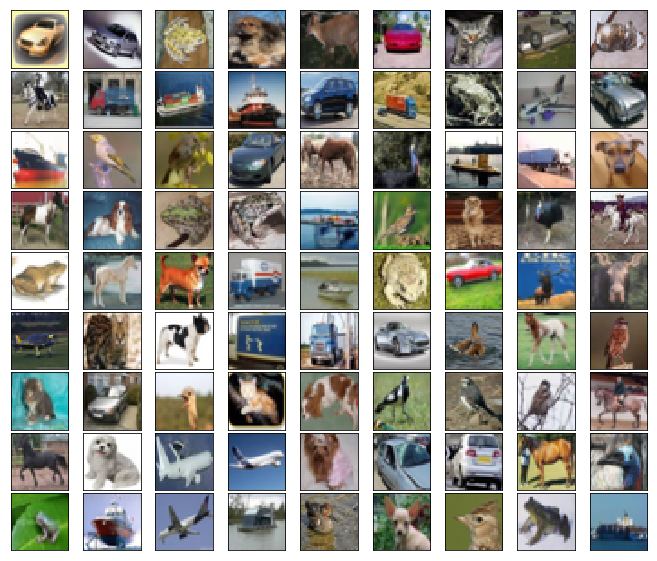

In [3]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

## 2. Data Augmentation

- Flipping (horizontally)
- Random cropping
- ...

### 2.1. Flipping (horizontally)

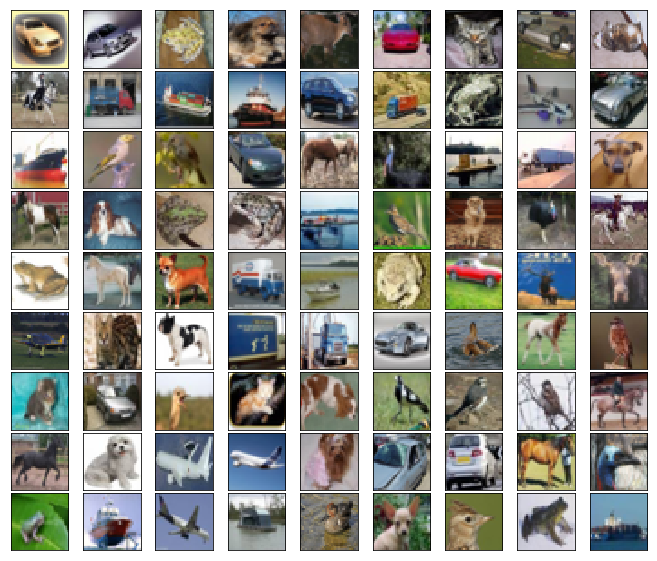

In [4]:
x_train_flip = x_train[:, :, ::-1, :]

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train_flip[i])

### 2.2. Random cropping

- サイズを同じにするために、拡大したあとcropping、paddingしてからcroppingなどの方法があります。
- cropは学習時に各バッチに対して行うことも多いです。
- 今回はDeep Residual Learning for Image Recognitionで使われた手法を実装します。

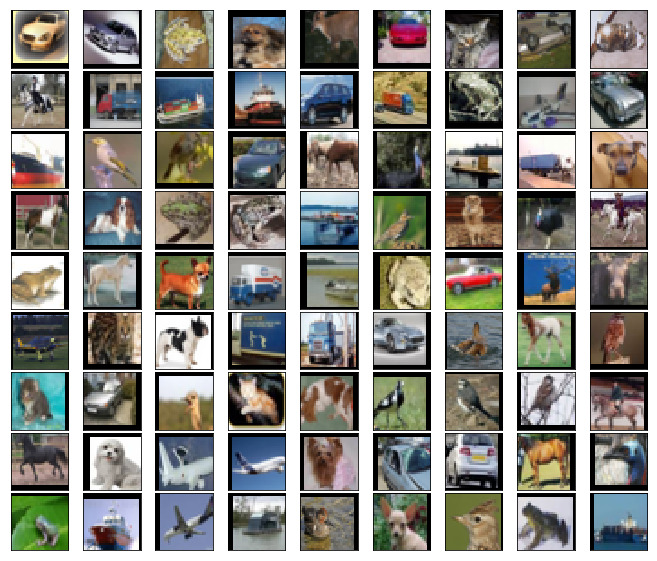

In [5]:
padded = np.pad(x_train, ((0, 0), (4, 4), (4, 4), (0, 0)), mode='constant')
crops = rng.randint(8, size=(len(x_train), 2))
x_train_cropped = [padded[i, c[0]:(c[0]+32), c[1]:(c[1]+32), :] for i, c in enumerate(crops)]
x_train_cropped = np.array(x_train_cropped)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train_cropped[i])

## 3. Preprocessing

- Global Contrast Normalization (GCN)
- ZCA Whitening

### 3.1. Global Contrast Normalization (GCN)

$$ {\bf x}^{norm} = \frac{{\bf x} - \bar{{\bf x}}}{\sqrt{\sigma_{{\bf x}}}} $$

- 通常の標準化とは違い，画像ごとに行います。
- コントラストが低くなります。

In [14]:
def gcn(x):
    mean = np.mean(x, axis=(1, 2, 3), keepdims=True)
    std = np.std(x, axis=(1, 2, 3), keepdims=True)
    return (x - mean)/std

In [7]:
x_train_normalized = gcn(x_train)

In [8]:
# 可視化用に画像を[0,1]にする&次元を変更
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    _x = _x
    return _x

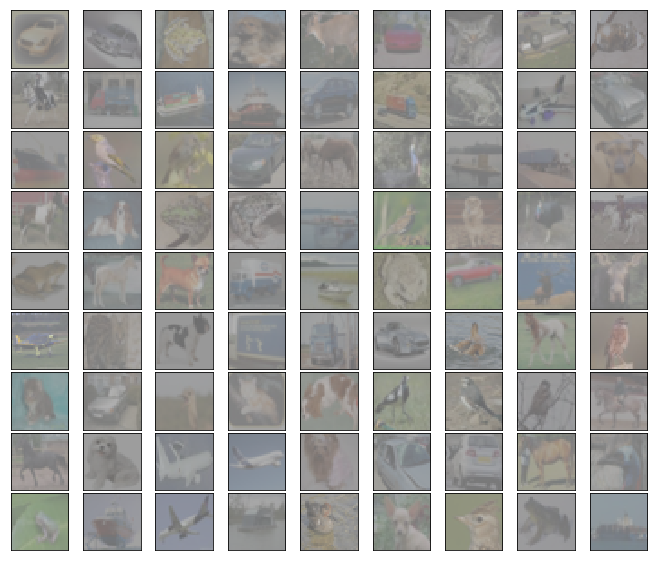

In [9]:
_x_train_normalized = deprocess(x_train_normalized)
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(_x_train_normalized[i])

del _x_train_normalized

### 3.2. Zero-phase Component Analysis (ZCA) Whitening

$$ {\bf x}^{ZCA} = A(\Lambda + \epsilon I)^{-\frac{1}{2}} A^{\mathrm{T}} ({\bf x} - \bar{\bf x}) $$

- np.linalg.svdを使うと便利です。（厳密にはnp.linalg.svdは特異値分解）

In [11]:
class ZCAWhitening:
    def __init__(self, epsilon=1e-4):
        self.epsilon = epsilon
        self.mean = None
        self.ZCA_matrix = None

    def fit(self, x):
        x = x.reshape(x.shape[0], -1) #画像表現を1ベクトル化 x : (n_data, 3072)
        self.mean = np.mean(x, axis=0) #平均は画素位置の平均
        x -= self.mean
        cov_matrix = np.dot(x.T, x) / x.shape[0] #画素位置ごとに、二乗和平均を求める（3072, 3072）
        A, d, _ = np.linalg.svd(cov_matrix)
        self.ZCA_matrix = np.dot(np.dot(A, np.diag(1. / np.sqrt(d + self.epsilon))), A.T)

    def transform(self, x):
        shape = x.shape
        x = x.reshape(x.shape[0], -1)
        x -= self.mean
        x = np.dot(x, self.ZCA_matrix.T)
        return x.reshape(shape)

In [11]:
zca = ZCAWhitening()
zca.fit(x_train)
x_train_zca = zca.transform(x_train)

In [12]:
# 可視化用に各画像ごとに[0,1]にする(ZCAの結果を見やすくするため)&次元を変更
def deprocess_each_img(x):
    _min = np.min(x, axis=(1, 2, 3), keepdims=True)
    _max = np.max(x, axis=(1, 2, 3), keepdims=True)
    _x = (x - _min)/(_max - _min)
    _x = _x
    return _x

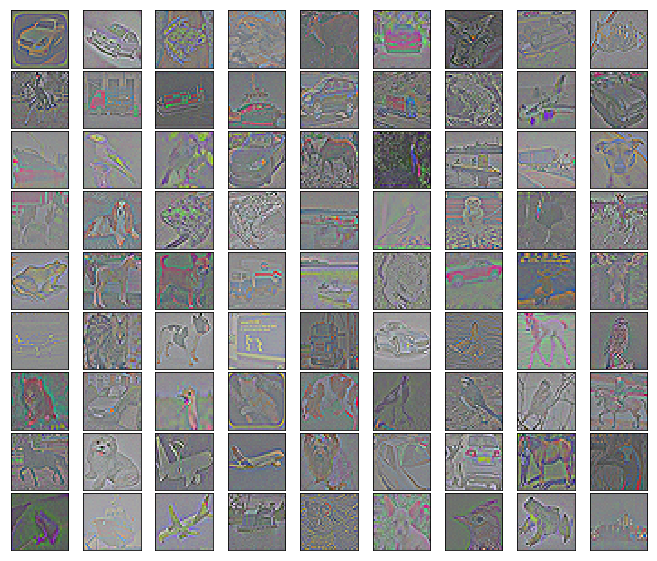

In [13]:
_x_train_zca = deprocess_each_img(x_train_zca)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(_x_train_zca[i])

del _x_train_zca

## 4. Batch Normalization

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [14]:
class BatchNorm:
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        self.gamma = tf.Variable(np.ones(shape, dtype='float32'), name='gamma')
        self.beta  = tf.Variable(np.zeros(shape, dtype='float32'), name='beta')
        self.epsilon = epsilon

    def __call__(self, x):
        mean, var = tf.nn.moments(x, axes=(0,1,2), keep_dims=True)
        std = tf.sqrt(var + self.epsilon) # WRITE ME (Hint: tf.sqrt)
        x_normalized = (x - mean) / std # WRITE ME
        return self.gamma * x_normalized + self.beta

## 5. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習

### 5.1. 各層クラスの実装

#### 畳み込み層

In [15]:
class Conv:
    def __init__(self, filter_shape, function=lambda x: x, strides=[1,1,1,1], padding='VALID'):
        fan_in = np.prod(filter_shape[:3])
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/fan_in),
                        high=np.sqrt(6/fan_in),
                        size=filter_shape
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros((filter_shape[3]), dtype='float32'), name='b') # バイアスはフィルタごと
        self.function = function
        self.strides = strides
        self.padding = padding

    def __call__(self, x):
        u = tf.nn.conv2d(x, self.W, strides=self.strides, padding=self.padding) + self.b
        return self.function(u)

#### プーリング層

In [16]:
class Pooling:
    def __init__(self, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
    
    def __call__(self, x):
        return tf.nn.max_pool(x, ksize=self.ksize, strides=self.strides, padding=self.padding)

#### 平滑化層（4次元->2次元）

In [17]:
class Flatten:
    def __call__(self, x):
        return tf.reshape(x, (-1, np.prod(x.get_shape().as_list()[1:])))

#### 全結合層

In [18]:
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/in_dim),
                        high=np.sqrt(6/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def __call__(self, x):
        return self.function(tf.matmul(x, self.W) + self.b)

#### 活性化層

In [19]:
class Activation:
    def __init__(self, function=lambda x: x):
        self.function = function
    
    def __call__(self, x):
        return self.function(x)

### 5.2. 計算グラフ構築 & パラメータの更新設定

In [4]:
# tf.log(0)によるnanを防ぐ
def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

In [21]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
t = tf.placeholder(tf.float32, [None, 10])

                                                                       # (縦の次元数)x(横の次元数)x(チャネル数)
conv_1 = Conv((3, 3, 3, 32))(x)               # 32x32x3 -> 30x30x32
h = BatchNorm((30, 30, 32))(conv_1)
h = Activation(tf.nn.relu)(h)
h = Pooling((1, 2, 2, 1))(h)                        # 30x30x32 -> 15x15x32
conv_2 = Conv((3, 3, 32, 64))(h)             # 15x15x32 -> 13x13x64
h = BatchNorm((13, 13, 64))(conv_2)
h = Activation(tf.nn.relu)(h)
h = Pooling(((1, 2, 2, 1)))(h)                      # 13x13x64 -> 6x6x64
conv_3 = Conv((3, 3, 64, 128))(h)          # 6x6x64 -> 4x4x128
h = BatchNorm((4, 4, 128))(conv_3)
h = Activation(tf.nn.relu)(h)
h = Pooling((1, 2, 2, 1))(h)                         # 4x4x128 -> 2x2x128
h = Flatten()(h)
h = Dense(2*2*128, 256, tf.nn.relu)(h)
y = Dense(256, 10, tf.nn.softmax)(h)

cost = - tf.reduce_mean(tf.reduce_sum(t * tf_log(y), axis=1))
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### 5.3. 学習

#### Preprocessing

In [15]:
zca = ZCAWhitening()
zca.fit(gcn(x_train))
x_train_zca = zca.transform(gcn(x_train))
t_train_zca = t_train[:]
x_valid_zca = zca.transform(gcn(x_valid))
t_valid_zca = t_valid[:]

#### 学習

In [ ]:
n_epochs = 10
batch_size = 100
n_batches = x_train.shape[0]//batch_size

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(n_epochs):
    x_train_zca, t_train_zca = shuffle(x_train_zca, t_train_zca, random_state=random_state)
    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        sess.run(train, feed_dict={x: x_train_zca[start:end], t: t_train_zca[start:end]})
    y_pred, cost_valid = sess.run([y, cost], feed_dict={x: x_valid_zca, t: t_valid_zca})
    print('EPOCH: {}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
        epoch,
        cost_valid,
        accuracy_score(t_valid.argmax(axis=1), y_pred.argmax(axis=1))
    ))

## 6. Activationの可視化

In [ ]:
plt.imshow(deprocess(x_train)[0])

### 6.1. conv_1

In [ ]:
output = sess.run(conv_1, feed_dict={x: x_train[0][None]})

In [ ]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(_output[0, :, :, i], cmap='gray')

### 6.2. conv_2

In [ ]:
output = sess.run(conv_2, feed_dict={x: x_train[0][None]})

In [ ]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(_output[0, :, :, i], cmap='gray')

### 6.3. conv_3

In [ ]:
output = sess.run(conv_3, feed_dict={x: x_train[0][None]})

In [ ]:
_output = deprocess(output)
fig = plt.figure(figsize=(10, 10))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(_output[0, :, :, i], cmap='gray')

In [ ]:
sess.close()

## 7. tf.layers の利用

これまで扱ってきたTensorflowの実装では比較的低レベルなAPIを使用してきました。それは本講義ではアルゴリズムの実装にフォーカスするためです。

しかしながら、実際にビジネスや研究で利用するときにはプリミティブな実装を一から書くのは手間になる場合もあります。そのような課題を解決するニーズに答え、Tensorflowには高レベルなAPIも用意されています。その一つに`tf.layers`というAPIがあります。

ここでは、`tf.layers`を使って、課題5の畳み込みニューラルネットワークの実装を行ってみましょう。


なお、このような高レベルなAPIは簡単に実装できる反面、実装の柔軟性が落ちるという欠点もあります。場合によって使い分ける必要があります。

`tf.layers`で使えるモジュールは以下のページで確認できます。

[Module: tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers)

### 7.1. ネットワークの実装

In [5]:
tf.reset_default_graph()

is_training = tf.placeholder(tf.bool, shape=()) # batch normalizationのために定義

x = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32)
t = tf.placeholder(tf.float32, [None, 10])

### ネットワーク ###
h = tf.layers.Conv2D(filters=32, kernel_size= [3, 3])(x) # 32x32x3 -> 30x30x32 # conv2dの初期設定: strides=(1, 1), padding='valid' 
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) # 30x30x32 -> 15x15x32

h = tf.layers.Conv2D(filters=64, kernel_size= [3, 3])(h) # 15x15x32 -> 13x13x64
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) # 13x13x64 -> 6x6x64

h = tf.layers.Conv2D(filters=128, kernel_size= [3, 3])(h) # 6x6x64 -> 4x4x128
h = tf.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) # 4x4x128 -> 2x2x128

h = tf.layers.Flatten()(h)
h = tf.layers.Dense(units=256, activation=tf.nn.relu)(h)
y = tf.layers.Dense(units=10, activation=tf.nn.softmax)(h)

cost = - tf.reduce_mean(tf.reduce_sum(t * tf_log(y), axis=1))

# batch normalizationのために記述しています。詳細: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

Instructions for updating:
Use tf.cast instead.


### 7.2. 学習

In [8]:
n_epochs = 10
batch_size = 100
n_batches = x_train.shape[0]//batch_size

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
for epoch in range(n_epochs):
    x_train_zca, t_train_zca = shuffle(x_train_zca, t_train_zca, random_state=random_state)
    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        sess.run(optimizer, feed_dict={x: x_train_zca[start:end], t: t_train_zca[start:end], is_training: True})
    y_pred, cost_valid = sess.run([y, cost], feed_dict={x: x_valid_zca, t: t_valid_zca, is_training: False})
    print('EPOCH: {}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
        epoch,
        cost_valid,
        accuracy_score(t_valid.argmax(axis=1), y_pred.argmax(axis=1))
    ))

In [ ]:
sess.close()